First Deep Learning Project https://theaisummer.com/learn-pytorch/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:', device)

device: cpu


In [3]:
# Data transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100.0%


In [12]:
x = torch.tensor([1., 1., 255.])
w = torch.tensor([0.1, 0.1, 0.1], requires_grad=True)
target = torch.tensor(10.0)
for i in range(100):
  with torch.no_grad():
    w.grad = torch.zeros(3)
  l = target - (x*w).sum()
  l.backward()  
  w = w - 0.01 * w.grad
print(f"Final weights {w.detach().numpy()}")

Final weights [0.11      0.11      2.6499999]


Images have a shape of torch.Size([3, 32, 32])
There are 10 with labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Label 6 which corresponds to frog will be converted to one-hot encoding by F.one_hot(torch.tensor(label),10)) as:  tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])


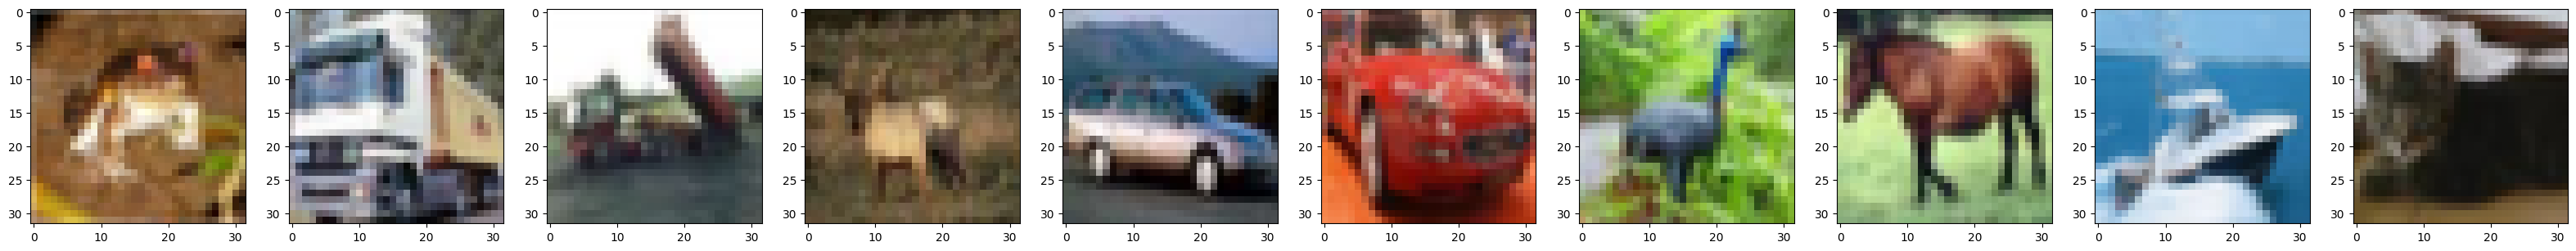

In [5]:
def imshow(img, i, mean, std):
    # undoes the normalization
    unnormalize = transforms.Normalize((-mean / std), (1.0 / std))
    plt.subplot(1, 10 ,i+1)
    npimg = unnormalize(img).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

img, label = trainset[0]
print(f"Images have a shape of {img.shape}")
print(f"There are {len(trainset.classes)} with labels: {trainset.classes}")

plt.figure(figsize = (40,20))
for i in range(10):
    imshow(trainset[i][0], i, mean=0.5, std=0.5)

print(f"Label {label} which corresponds to {trainset.classes[label]} will be converted to one-hot encoding by F.one_hot(torch.tensor(label),10)) as: ", F.one_hot(torch.tensor(label),10))

In [6]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

val_loader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=False)

In [7]:
# dataset instance
print("List of label names are:", trainset.classes)
print("Total training images:", len(trainset))
img, label = trainset[0]
print(f"Example image with shape {img.shape}, label {label}, which is a {trainset.classes[label]} ")

# DataLoader instance
print(f'The dataloader contains {len(train_loader)} batches of batch size {train_loader.batch_size} and {len(train_loader.dataset)} images')
imgs_batch , labels_batch = next(iter(train_loader))
print(f"A batch of images has shape {imgs_batch.shape}, labels {labels_batch.shape}")

List of label names are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Total training images: 50000
Example image with shape torch.Size([3, 32, 32]), label 6, which is a frog 
The dataloader contains 196 batches of batch size 256 and 50000 images
A batch of images has shape torch.Size([256, 3, 32, 32]), labels torch.Size([256])


In [8]:
class MLP(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_sizes=[64]):
        super(MLP, self).__init__()
        assert len(hidden_sizes) >= 1 , "specify at least one hidden layer"
        layers = nn.ModuleList()
        layer_sizes = [in_channels] + hidden_sizes
        for dim_in, dim_out in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(dim_in, dim_out))
            layers.append(nn.ReLU())

        self.layers = nn.Sequential(*layers)
        self.out_layer = nn.Linear(hidden_sizes[-1], num_classes)

    def forward(self, x):
        out = x.view(x.shape[0], -1)
        out = self.layers(out)
        out = self.out_layer(out)
        return out

In [9]:
def validate(model, val_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = 0
    loss_step = []
    with torch.no_grad():
        for inp_data, labels in val_loader:
            # Move the data to the GPU
            labels = labels.view(labels.shape[0]).to(device)
            inp_data = inp_data.to(device)
            outputs = model(inp_data)
            val_loss = criterion(outputs, labels)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum()
            loss_step.append(val_loss.item())
        val_acc = (100 * correct / len(val_loader.dataset)).cpu().numpy()
        val_loss_epoch = torch.tensor(loss_step).mean().numpy()
        return val_acc , val_loss_epoch

In [10]:
def train_one_epoch(model, optimizer, train_loader, device):
    model.train()
    criterion = nn.CrossEntropyLoss()
    loss_step = []
    correct, total = 0, 0
    for (inp_data, labels) in train_loader:
        # Move the data to the GPU
        labels = labels.view(labels.shape[0]).to(device)
        inp_data = inp_data.to(device)
        outputs = model(inp_data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
            loss_step.append(loss.item())
    # means computation
    loss_curr_epoch = np.mean(loss_step)
    train_acc = (100 * correct / total).cpu()

    return loss_curr_epoch, train_acc

def train(model, optimizer, num_epochs, train_loader, val_loader, device):
    best_val_loss = 1000
    best_val_acc = 0
    model = model.to(device)
    dict_log = {"train_acc_epoch":[], "val_acc_epoch":[], "loss_epoch":[], "val_loss":[]}

    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        loss_curr_epoch, train_acc = train_one_epoch(model, optimizer, train_loader, device)
        val_acc, val_loss = validation(model, val_loader, device)
        # Print epoch results to screen
        msg = (f'Ep {epoch}/{num_epochs}: Accuracy: Train:{train_acc:.2f} Val:{val_acc:.2f} \
                || Loss: Train {loss_curr_epoch:.3f} Val {val_loss:.3f}')
        pbar.set_description(msg)
        # Track stats
        dict_log["train_acc_epoch"].append(train_acc)
        dict_log["val_acc_epoch"].append(val_acc)
        dict_log["loss_epoch"].append(loss_curr_epoch)
        dict_log["val_loss"].append(val_loss)
    return dict_log

In [13]:
# Model settings
in_channels = 3 * 32 * 32
num_classes = 10
hidden_sizes = [128]
# hyper-parameters
epochs = 50
lr = 1e-3
momentum = 0.9
wd = 1e-4
device = "cuda"
model = MLP(in_channels, num_classes, hidden_sizes).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=wd)
dict_log = train(model, optimizer, epochs, train_loader, val_loader, device)

AssertionError: Torch not compiled with CUDA enabled